# FERC to FERC Match

A classifier for identifying FERC plant time series in FERC Form 1 data.

Input: FERC plant record  
Output: The ID of the group of records that it ought to be part of

Training data: A list of lists of unique FERC plant record IDs (each record ID is the concatenation of: report year, respondent id, supplement number, and row number). It could also be stored as a dataframe where each column is associated with a year of data(some of which could be empty). Not sure what the best structure would be.

In [1]:
%load_ext autoreload
%autoreload 3

In [129]:
import faiss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from pudl.etl import defs
from ferc1_eia_match.name_cleaner import CompanyNameCleaner
from ferc1_eia_match.candidate_set_creation import DataframeEmbedder
from ferc1_eia_match import config

## Get input data

In [3]:
# use denorm_plants_all_ferc1 instead?
plants_df = defs.load_asset_value("denorm_plants_steam_ferc1")

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Running stamp_revision  -> ec80dd91891a
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Running stamp_revision  -> ec80dd91891a
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Running stamp_revision  -> ec80dd91891a
INFO:alembic.runtime.migration:Context impl SQLiteImpl.

In [4]:
fuel_df = defs.load_asset_value("denorm_fuel_by_plant_ferc1")

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Running stamp_revision  -> ec80dd91891a
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Running stamp_revision  -> ec80dd91891a
INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:alembic.runtime.migration:Running stamp_revision  -> ec80dd91891a
INFO:alembic.runtime.migration:Context impl SQLiteImpl.

In [5]:
fuel_cols = list(fuel_df.filter(regex=".*_fraction_mmbtu$").columns)

In [6]:
plants_df = plants_df.merge(
    fuel_df[["utility_id_ferc1", "plant_name_ferc1", "report_year"] + fuel_cols],
    on=["utility_id_ferc1", "plant_name_ferc1", "report_year"],
    how="left",
)

In [7]:
utility_name_cleaner = CompanyNameCleaner()
# default rules except keep words in parentheses
plant_name_cleaner = CompanyNameCleaner(
    cleaning_rules_list=[
        "replace_amperstand_between_space_by_AND",
        "replace_hyphen_between_spaces_by_single_space",
        "replace_underscore_by_space",
        "replace_underscore_between_spaces_by_single_space",
        "remove_text_puctuation_except_dot",
        "remove_math_symbols",
        "add_space_before_opening_parentheses",
        "add_space_after_closing_parentheses",
        "remove_parentheses",
        "remove_brackets",
        "remove_curly_brackets",
        "enforce_single_space_between_words",
    ]
)

In [8]:
plants_df = (
    plants_df.pipe(
        utility_name_cleaner.get_clean_df,
        "utility_name_ferc1",
        "utility_name",
    )
    .pipe(plant_name_cleaner.get_clean_df, "plant_name_ferc1", "plant_name")
)

Probably should adapt the DataframeEmbedder class to function with a "pipeline"-like structure for all these embedding functions.

Vectorize FERC data:  
* plant_name (via TF-IDF, with ngram_min and ngram_max as parameters)
* plant_type (OneHot encoded categorical feature)
* construction_type (OneHot encoded categorical feature)
* capacity_mw (MinMax scaled numerical feature)
* construction year (OneHot encoded categorical feature)
* utility_id_ferc1 (OneHot encoded categorical feature)
* fuel_fraction_mmbtu (several MinMax scaled numerical columns, which are
normalized and treated as a single feature.)

Note: Integer nulls are filled with 0 in the PUDL module

In [9]:
ngram_min=2
ngram_max=10
plant_name_ferc1_wt=2.0
plant_type_wt=2.0
construction_type_wt=1.0
capacity_mw_wt=1.0
construction_year_wt=1.0
utility_id_ferc1_wt=1.0
fuel_fraction_wt=1.0

In [10]:
str_cols = ["plant_type", "construction_type"]
num_cols = ["capacity_mw", "construction_year", "utility_id_ferc1"] + fuel_cols

In [11]:
plants_df[str_cols] = plants_df[str_cols].astype(str).fillna("").astype("category")

In [12]:
plants_df[num_cols] = plants_df[num_cols].fillna(0)

In [13]:
embedder = ColumnTransformer(
    transformers=[
        (
            "plant_name_ferc1",
            TfidfVectorizer(
                analyzer="char", ngram_range=(ngram_min, ngram_max)
            ),
            "plant_name_ferc1",
        ),
        (
            "plant_type",
            OneHotEncoder(categories="auto"),
            ["plant_type"],
        ),
        (
            "construction_type",
            OneHotEncoder(categories="auto"),
            ["construction_type"],
        ),
        ("capacity_mw", MinMaxScaler(), ["capacity_mw"]),
        (
            "construction_year",
            OneHotEncoder(categories="auto"),
            ["construction_year"],
        ),
        (
            "utility_id_ferc1",
            OneHotEncoder(categories="auto"),
            ["utility_id_ferc1"],
        ),
        (
            "fuel_fraction_mmbtu",
            Pipeline(
                [("scaler", MinMaxScaler()), ("norm", Normalizer())]
            ),
            fuel_cols,
        ),
    ],
    transformer_weights={
        "plant_name_ferc1": plant_name_ferc1_wt,
        "plant_type": plant_type_wt,
        "construction_type": construction_type_wt,
        "capacity_mw": capacity_mw_wt,
        "construction_year": construction_year_wt,
        "utility_id_ferc1": utility_id_ferc1_wt,
        "fuel_fraction_mmbtu": fuel_fraction_wt,
    },
)

In [14]:
plants_matrix_sparse = embedder.fit_transform(plants_df)

In [15]:
plants_matrix_sparse.shape

(30825, 80576)

In [16]:
plants_df.plant_id_ferc1.max()

7144

In [111]:
%%time
d = plants_matrix_sparse.shape[1]
plants_matrix = np.float32(plants_matrix_sparse.todense())

CPU times: user 7.52 s, sys: 13.1 s, total: 20.6 s
Wall time: 23.5 s


In [113]:
plants_small = plants_matrix[:2000]

In [114]:
plants_small_df = plants_df[:2000].copy()

In [116]:
%%time
pca_small = PCA(n_components=500)
plants_small_pca = pca_small.fit_transform(np.asarray(plants_small))

CPU times: user 17.8 s, sys: 1.06 s, total: 18.9 s
Wall time: 20 s


In [79]:
%%time
pca = PCA(n_components=500)
plants_matrix_pca = pca.fit_transform(plants_matrix)

CPU times: user 9min 52s, sys: 2min 57s, total: 12min 49s
Wall time: 24min 26s


In [44]:
# similarity threshold of .75 is used in the PUDL module, but we need a distance threshold
d_threshold = .3

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering_metrics.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-metrics-py

Maybe cosine distance isn't the best metric here even though it's used in the PUDL module

What are we optimizing for? 
- largest possible clusters so there are few straggler records
- no overlapping report years within a cluster

In [76]:
%%time
# use the distance matrix and pass it into sklearn agglomerative clustering
agg_clustering_small = AgglomerativeClustering(n_clusters=None,
                                         metric="euclidean",
                                         # connectivity=similarities,
                                         linkage="single",
                                         distance_threshold=d_threshold)
labels = agg_clustering_small.fit_predict(np.asarray(plants_small_pca))

CPU times: user 621 ms, sys: 14.4 ms, total: 635 ms
Wall time: 657 ms


In [77]:
plants_small_df["id"] = labels

In [78]:
# do records with the same record year end up in the same group?
# is there a way to build this restriction into the classifier?
# could add a "distance to the rest of the cluster" metric and choose the record with smaller distance
plants_small_df.groupby(by=["id", "report_year"]).size().value_counts()

1    1946
2      15
4       6
Name: count, dtype: int64

<Axes: >

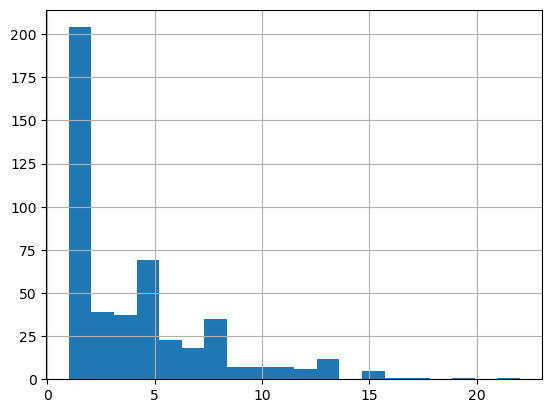

In [59]:
plants_small_df.groupby(by=["id"]).size().hist(bins=20)

In [92]:
plants_small_df.groupby("id").plant_id_ferc1.nunique().value_counts().sort_index()

plant_id_ferc1
1     400
2      12
3       3
4       7
5      16
6       5
7       1
8       1
10      1
11      1
12      1
13      5
16      1
19      1
Name: count, dtype: int64

In [80]:
%%time
# run on all data
agg_clustering = AgglomerativeClustering(n_clusters=None,
                                         metric="euclidean",
                                         linkage="single",
                                         distance_threshold=d_threshold)
labels = agg_clustering.fit_predict(np.asarray(plants_matrix_pca))

CPU times: user 4min 1s, sys: 4.42 s, total: 4min 5s
Wall time: 4min 27s


In [81]:
plants_labels_df = plants_df.copy()

In [82]:
plants_labels_df["id"] = labels

In [83]:
# do records with the same record year end up in the same group?
# is there a way to build this restriction into the classifier?
# could add a "distance to the rest of the cluster" metric and choose the record with smaller distance
plants_labels_df.groupby(by=["id", "report_year"]).size().value_counts()

1     29534
2       522
3        38
4        15
5         4
10        1
17        1
7         1
19        1
Name: count, dtype: int64

<Axes: >

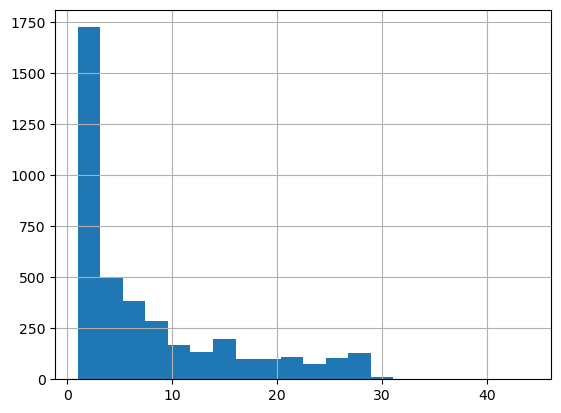

In [84]:
plants_labels_df.groupby(by=["id"]).size().hist(bins=20)

In [93]:
# clusters should probably be larger?
plants_labels_df.groupby("id").size().mean()

7.656482861400894

In [94]:
plants_labels_df.id.max()

4025

In [91]:
plants_labels_df.groupby("id").plant_id_ferc1.nunique().value_counts().sort_index().head(10)

plant_id_ferc1
1     3441
2      123
3       78
4       43
5       56
6       32
7       35
8       19
9       17
10      11
Name: count, dtype: int64

What is the average distance between records in a group?

In [106]:
labels.min(),labels.max()

(0, 4025)

In [126]:
%%time
index = faiss.IndexFlatL2(500)
index.add(np.float32(plants_matrix_pca))
avg_distances = []
for i in range(labels.max() + 1):
    cluster_idx = np.where(labels == i)
    d, _ = index.search(plants_matrix_pca[cluster_idx], len(cluster_idx))
    avg_distances.append(d.mean())

CPU times: user 1min 37s, sys: 2.07 s, total: 1min 39s
Wall time: 1min 38s


In [147]:
# the distances are really small, adjust clustering accordingly?
pd.Series(avg_distances).value_counts().sort_index()

0.000000e+00    3715
1.833989e-08       2
1.907349e-08       1
2.073205e-08       1
2.270653e-08       2
                ... 
5.616082e-06       1
5.865097e-06       1
5.960464e-06       1
6.085350e-06       1
6.176177e-06       1
Name: count, Length: 212, dtype: int64

### Try using FAISS to generate connectivity matrix

In [20]:
%%time
faiss.normalize_L2(plants_small)
# use the Inner Product Index, which is equivalent to cosine sim for normalized vectors
index = faiss.IndexFlatIP(d)
index.add(plants_small)

CPU times: user 194 ms, sys: 130 ms, total: 324 ms
Wall time: 368 ms


In [21]:
%%time
# I feel like this shouldn't take this long, maybe something is messed up with threading
similarities, neighbors = index.search(plants_small, plants_small.shape[0])

CPU times: user 4.37 s, sys: 43.3 ms, total: 4.42 s
Wall time: 1.44 s


In [22]:
similarities.shape

(1000, 1000)

In [ ]:
np.all(np.abs(similarities-similarities.T) < 1e-8)

In [ ]:
%%time
# this doesn't seem to work
# use the distance matrix and pass it into sklearn agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters=None,
                                         metric="cosine", # try using "cosine", but is that a similarity?
                                         connectivity=similarities,
                                         linkage="single",
                                         distance_threshold=d_threshold)
labels = agg_clustering.fit_predict(np.asarray(plants_small))

Graph the results

Deal with orphaned records